In [63]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from keras_vggface import utils
from keras_vggface.vggface import VGGFace
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Flatten, Layer, Conv2D, Lambda, MaxPooling2D
from keras import regularizers
from keras.losses import categorical_crossentropy
import keras.utils
from keras import backend as K

## Step 1: Prepare the training data
Define the path to the face data directory

In [64]:
data_dir = 'face_data'

Load the face images and labels

In [65]:
X_train = []
y_train = []
for person_name in os.listdir(data_dir):
    person_dir = os.path.join(data_dir, person_name)
    for image_name in os.listdir(person_dir):
        image_path = os.path.join(person_dir, image_name)
        image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        X_train.append(tf.keras.utils.img_to_array(image))
        y_train.append(person_name)

Show image

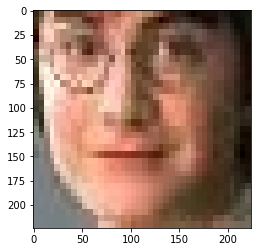

In [104]:
plt.imshow(X_train[4].astype('uint8'), interpolation='nearest')
plt.show()

number of label

In [67]:
num_classes = len(os.listdir(data_dir))

Convert the face images and labels to numpy arrays

In [68]:
X_train = np.array(X_train)
y_train = np.array(y_train)

Label-encode the person names

In [69]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

## Step 2: ArcFace

ArcFace Layer

In [70]:
class ArcFaceLayer(Layer):
    def __init__(self, num_classes, m=0.5, s=64.0, regularizer=None, **kwargs):
        super(ArcFaceLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.regularizer = regularizer
        self.m = m
        self.s = s

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.num_classes),
                                 initializer='glorot_uniform',
                                 trainable=True, 
                                 regularizer=self.regularizer,
                                 name='W')
        
    def call(self, inputs):
        # normalize input features
        x = tf.nn.l2_normalize(inputs, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product between features and weights
        logits = tf.matmul(x, W)
        return logits

ArcFace loss function

In [71]:
def arcface_loss(y_true, y_pred, m=0.5, s=64.0):
    # normalize input features
    embeddings = tf.nn.l2_normalize(y_pred, axis=1)

    # normalize weights
    W = tf.nn.l2_normalize(tf.ones((embeddings.shape[1], y_true.shape[1])), axis=0)

    # compute logits
    logits = tf.matmul(embeddings, W)

    # add margin
    theta = tf.acos(tf.clip_by_value(logits, -1.0 + tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon()))
    target_logits = tf.cos(theta + m)

    # multiply with scaling parameter
    logits *= s

    # apply cross-entropy loss
    logits_softmax = tf.nn.softmax(logits, axis=-1)
    ce_loss = tf.losses.categorical_crossentropy(y_true, logits_softmax)

    # add the ArcFace margin loss
    target_logits_softmax = tf.nn.softmax(target_logits, axis=-1)
    arcface_loss = tf.losses.categorical_crossentropy(y_true, target_logits_softmax)

    return ce_loss + arcface_loss


## Step 4: Define model

Define the VGG-Face model as the feature extraction backbone

In [72]:
backbone = VGGFace(model='vgg16', include_top=False,
                   input_shape=(224, 224, 3), pooling='avg')

Define the full face recognition model

In [73]:
from torch import conv1d


model = Sequential([
     # Input layer
    Input(shape=(224, 224, 3)),
    
    # Convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the features
    Flatten(),
    
    # Fully connected layers
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    
    ArcFaceLayer(num_classes=num_classes,
            regularizer=regularizers.l2(0.01))
])

## Step 4: compile model

compile model

In [74]:
model.compile(loss=arcface_loss,
              optimizer='adam', metrics=['accuracy'])

## Step 5: Train the model

Load model

In [75]:
# try:
#   model = keras.models.load_model(os.getcwd())
# except:
#   print('error')
#   pass

Convert the training labels to one-hot encoded vectors

In [76]:
y_train_onehot = keras.utils.np_utils.to_categorical(
    y_train, num_classes=num_classes)

save model

In [77]:
# model.save(os.getcwd())

Train the face recognition model

In [94]:
model.fit(X_train, y_train_onehot, batch_size=32,
          epochs=10, validation_split=0.1)

Epoch 1/520
1/1 [==============================] - 1s 999ms/step - loss: 2.7728 - accuracy: 0.2500 - val_loss: 2.7728 - val_accuracy: 0.0000e+00
Epoch 2/520
1/1 [==============================] - 1s 1s/step - loss: 2.7728 - accuracy: 0.2500 - val_loss: 2.7728 - val_accuracy: 0.0000e+00
Epoch 3/520
1/1 [==============================] - 1s 906ms/step - loss: 2.7728 - accuracy: 0.5000 - val_loss: 2.7728 - val_accuracy: 0.0000e+00
Epoch 4/520
1/1 [==============================] - 1s 988ms/step - loss: 2.7728 - accuracy: 0.0000e+00 - val_loss: 2.7728 - val_accuracy: 0.0000e+00
Epoch 5/520
1/1 [==============================] - 1s 1s/step - loss: 2.7728 - accuracy: 0.2500 - val_loss: 2.7728 - val_accuracy: 0.0000e+00
Epoch 6/520
1/1 [==============================] - 1s 897ms/step - loss: 2.7728 - accuracy: 0.2500 - val_loss: 2.7728 - val_accuracy: 0.0000e+00
Epoch 7/520
1/1 [==============================] - 1s 934ms/step - loss: 2.7728 - accuracy: 0.0000e+00 - val_loss: 2.7728 - val_accu

## Step 6: Predict

In [97]:
# Load image
image_path = 'D:/PPNCKH/test/mk.jpg'
image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(image)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x)

# Use the trained model to make a prediction
prediction = model.predict(x)

print(prediction)

print(label_encoder.inverse_transform(y_train)[np.argmax(prediction)])

1/1 [==============================] - 0s 55ms/step
[[0.6675816  0.6033869  0.78126115 0.66552234]]
Christian_Olsson
